In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import imblearn as im
import numpy as np
import seaborn as sns
import snowflake.connector
import statsmodels.api as sm
from snowflake.connector.pandas_tools import write_pandas
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
# snowlake connection
conn = snowflake.connector.Connect(user='ANALYST', password='Fedewap2023!', account='rl43903.east-us-2.azure')
sql = "select timeline.*, coalesce(surveys.form_responses, 0) as form_responses, coalesce(surveys.avg_form_sentiment, 0) as avg_form_sentiment, coalesce(surveys.avg_nps, 0) as avg_nps from (select * from CHICAGOFIRE_DATABASE.MODELING.STM_TIMELINE) as timeline left join (select EMAIL, year(event_date) as season_year, count(EVENT) as form_responses, avg(detail:sentiment[0]) as avg_form_sentiment, avg(detail:nps) as avg_nps from CHICAGOFIRE_DATABASE.MODELING.FAN_TIMELINE where lower(event) like '%form_response%' and EMAIL is not NULL and not lower(EMAIL) like 'none' group by EMAIL, year(event_date)) as surveys on timeline.EMAIL = surveys.EMAIL and timeline.SEASON_YEAR = surveys.SEASON_YEAR"
res = conn.cursor().execute(sql).fetchall()
#load in dataset
df = pd.read_sql(sql, conn)

C:\Users\dgilbert\AppData\Local\Temp\ipykernel_22904\2893316718.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


Pre-processing

In [3]:
df = df[df['SEASON_TICKET_MEMBER'] == 1]
df.fillna(0, inplace=True)
df['MLS_YEAR_TENURE'] = df['MLS_DAY_TENURE']/365.25

#Dropping vendors
df['ACCT_ID'] = df['ACCT_ID'].astype('int64')
ids_to_drop = [3790591, 295808, 348953, 31405, 114785, 4513005, 3496760]
df = df[~df['ACCT_ID'].isin(ids_to_drop)]

#Convert attendance to attendance rate
games_21 = 11 #could go to 16
games_22 = 18
games_23 = 22
df['ATTENDANCE_RATE'] = np.nan
df['SEASON_YEAR'] = df['SEASON_YEAR'].astype('int64')
df.loc[df.SEASON_YEAR == 2021, 'ATTENDANCE_RATE'] = df.loc[df.SEASON_YEAR == 2021, 'ATTEND_COUNT']/games_21
df.loc[df.SEASON_YEAR == 2022, 'ATTENDANCE_RATE'] = df.loc[df.SEASON_YEAR == 2022, 'ATTEND_COUNT']/games_22
df.loc[df.SEASON_YEAR == 2023, 'ATTENDANCE_RATE'] = df.loc[df.SEASON_YEAR == 2023, 'ATTEND_COUNT']/games_23

#Sum SF Fields
df['SF_SUM'] = df['SF_EMAILS'] + df['SF_LISTEMAILS'] + df['SF_CADENCES'] + df['SF_CALLS'] + df['SF_EVENTS'] + df['SF_TASKS']

#Combine forward and return counts
df['FORWARD_AND_RETURN'] = df['FORWARD_COUNT'] + df['RETURN_COUNT']

#Merch Binary
df['MERCH_BINARY'] = (df['MERCH_PURCHASES'] > 0).astype(int)

#Combine ticket and merch spend
df['SPEND'] = df['MERCH_SPEND'] + df['TICKET_SPEND']

#Combine Emails
df['EMAILS'] = df['SF_LISTEMAILS'] + df['SF_EMAILS']

In [4]:
df.isna().sum()

ACCT_ID                  0
EMAIL                    0
SEASON_YEAR              0
SEASON_TICKET_MEMBER     0
TICKET_COUNT             0
TICKET_SPEND             0
SUM_TICKET_COUNT         0
SUM_TICKET_SPEND         0
ATTEND_COUNT             0
RECEIVE_FORWARD_COUNT    0
FORWARD_COUNT            0
RETURN_COUNT             0
MERCH_PURCHASES          0
MERCH_SPEND              0
EMAIL_CLICKS             0
TICKET_EMAIL_CLICKS      0
CFYSC_REGISTRATIONS      0
SF_TASKS                 0
SF_LISTEMAILS            0
SF_EVENTS                0
SF_EMAILS                0
SF_CALLS                 0
SF_CADENCES              0
MLS_DAY_TENURE           0
ROOKIE                   0
RENEWED_NEXT_YEAR        0
FORM_RESPONSES           0
AVG_FORM_SENTIMENT       0
AVG_NPS                  0
MLS_YEAR_TENURE          0
ATTENDANCE_RATE          0
SF_SUM                   0
FORWARD_AND_RETURN       0
MERCH_BINARY             0
SPEND                    0
dtype: int64

C:\Users\dgilbert\AppData\Local\Temp\ipykernel_22904\360779703.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

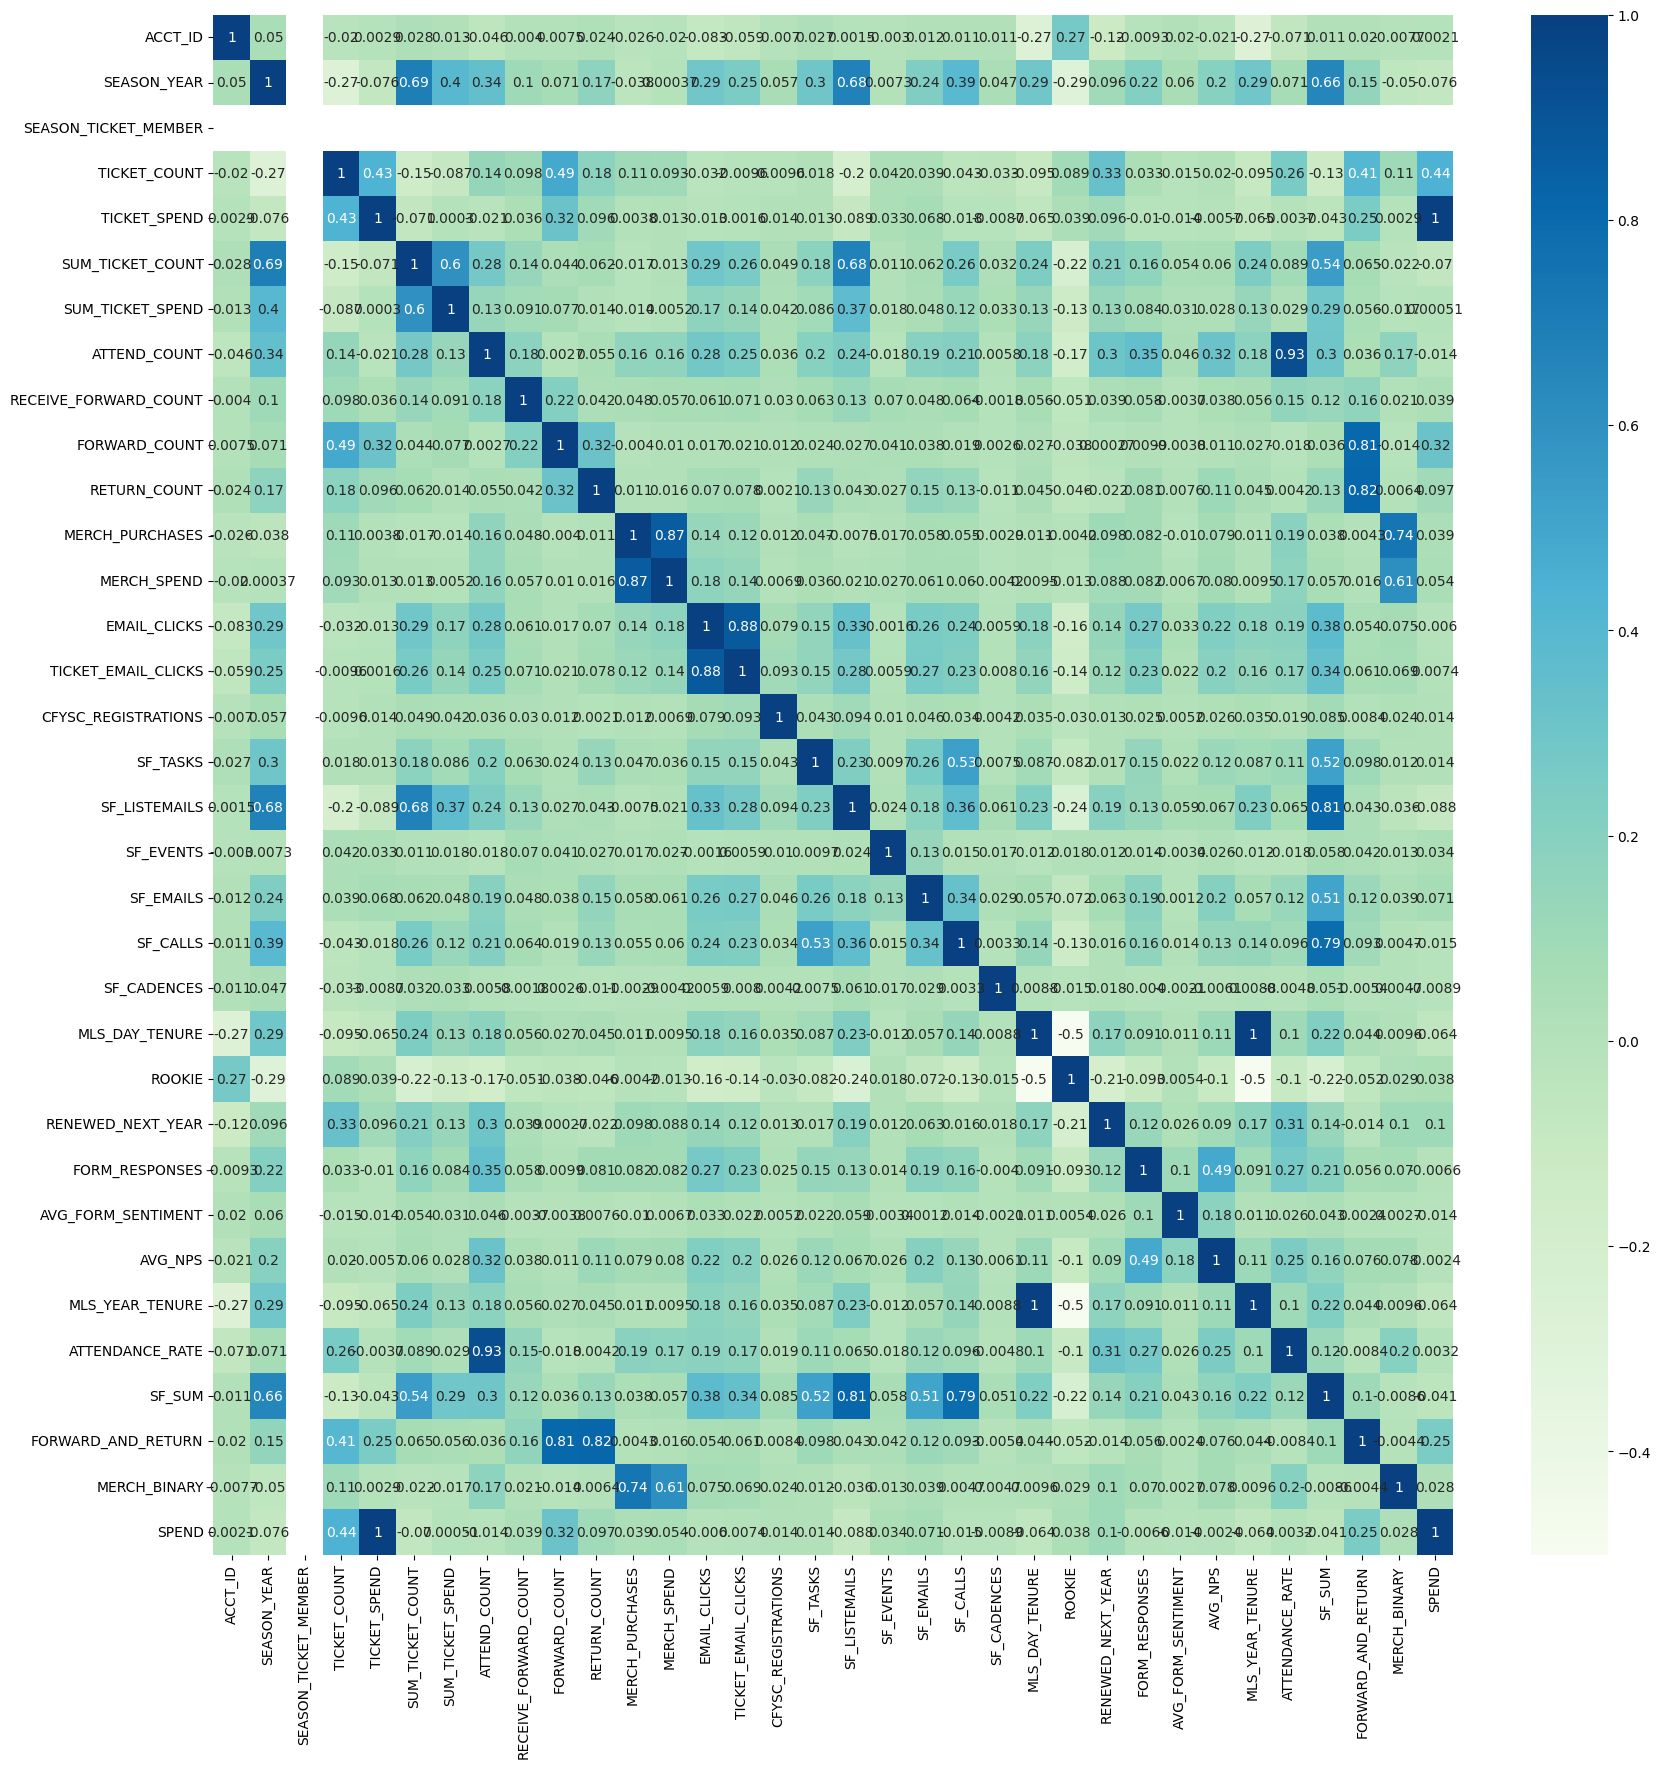

In [13]:
df.shape
df.describe()
corr = df.corr()
corr.to_csv("C:/Users/dgilbert/Desktop/Code/Member Scoring Model/correlation_matrix_msm.csv")
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap="GnBu", annot=True)

Initial Model

In [122]:
# All features
X = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'ROOKIE', 'MLS_YEAR_TENURE']
y = df['RENEWED_NEXT_YEAR']

In [123]:
Xtrain = df[X]
X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.2)

Logisitic Regression

Accuracy:  0.7890909090909091
Precison:  0.8116959064327486
Recall:  0.9071895424836601


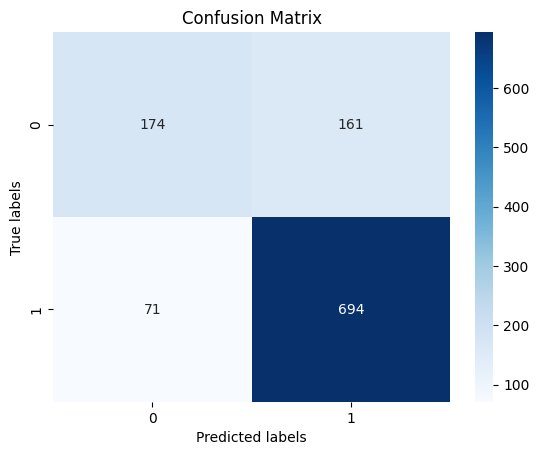

In [120]:
model = LogisticRegression(max_iter=3000).fit(X_train, y_train)
predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions)
test_recall = recall_score(y_test, predictions)
print("Accuracy: ", test_accuracy)
print("Precison: ", test_precision)
print("Recall: ", test_recall)

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Random Forest

Accuracy:  0.79
Precison:  0.8272058823529411
Recall:  0.8823529411764706


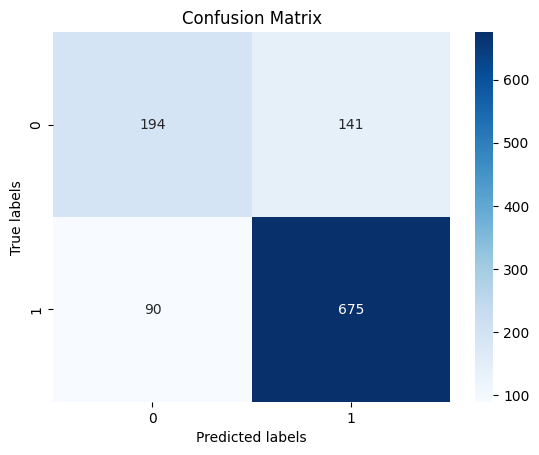

In [121]:
rf = RandomForestClassifier()
model = rf.fit(X_train, y_train)
predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions)
test_recall = recall_score(y_test, predictions)
print("Accuracy: ", test_accuracy)
print("Precison: ", test_precision)
print("Recall: ", test_recall)

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Feature Importance

In [62]:
# All features
X = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'ROOKIE', 'MLS_YEAR_TENURE']
y = df['RENEWED_NEXT_YEAR']

In [63]:
Xtrain = df[X]
#Standardizer
scaler = StandardScaler()
Xtrain_standard = scaler.fit_transform(Xtrain)
Xtrain_standard = pd.DataFrame(Xtrain_standard)
Xtrain_standard.columns = Xtrain.columns

X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.2)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xtrain_standard, y, test_size=0.2)

In [64]:
model = LogisticRegression().fit(X_train, y_train)
model_s = LogisticRegression().fit(X_train_s, y_train_s)

In [65]:
# Get the coefficients
coefficients = model.coef_[0]
coefficients_standard = model_s.coef_[0]

# Create a DataFrame for easy viewing
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_names_s = X_train_s.columns
importance_df = pd.DataFrame({'Feature': feature_names_s, 'Standardized Coefficients': coefficients_standard})

In [66]:
coef_df

,Feature,Coefficient
0,ATTENDANCE_RATE,2.322214
1,TICKET_COUNT,0.113663
2,ROOKIE,-1.034390
3,MLS_YEAR_TENURE,0.133480


In [67]:
importance_df

,Feature,Standardized Coefficients
0,ATTENDANCE_RATE,0.545525
1,TICKET_COUNT,1.227550
2,ROOKIE,-0.488733
3,MLS_YEAR_TENURE,0.270377


Include broken out by variable type importance

In [306]:
#Ticketing
Ticketing = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'TICKET_SPEND', 'FORWARD_AND_RETURN', 'MLS_YEAR_TENURE', 'ROOKIE']
#Merch
Merch = ['MERCH_BINARY', 'MERCH_SPEND', 'MLS_YEAR_TENURE', 'ROOKIE']
#Formstack sentiment
Sentiment = ['FORM_RESPONSES', 'AVG_FORM_SENTIMENT', 'AVG_NPS', 'MLS_YEAR_TENURE', 'ROOKIE']
#Email interactions
Emails = ['EMAIL_CLICKS', 'MLS_YEAR_TENURE', 'ROOKIE']
#Salesforce Rep Interactions
Reps = ['SF_TASKS', 'SF_EMAILS', 'SF_LISTEMAILS', 'SF_CALLS', 'SF_CADENCES', 'SF_EVENTS', 'MLS_YEAR_TENURE', 'ROOKIE']#, SF_SUM]

In [307]:
Xtrain = df[Reps]
#Standardizer
scaler = StandardScaler()
Xtrain_standard = scaler.fit_transform(Xtrain)
Xtrain_standard = pd.DataFrame(Xtrain_standard)
Xtrain_standard.columns = Xtrain.columns

X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.2)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xtrain_standard, y, test_size=0.2)

In [308]:
model = LogisticRegression().fit(X_train, y_train)
model_s = LogisticRegression().fit(X_train_s, y_train_s)

In [309]:
# Get the coefficients
coefficients = model.coef_[0]
coefficients_standard = model_s.coef_[0]

# Create a DataFrame for easy viewing
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_names_s = X_train_s.columns
importance_df = pd.DataFrame({'Feature': feature_names_s, 'Standardized Coefficients': coefficients_standard})

In [310]:
coef_df

,Feature,Coefficient
0,SF_TASKS,-0.002012
1,SF_EMAILS,0.017171
2,SF_LISTEMAILS,0.033978
3,SF_CALLS,-0.020152
4,SF_CADENCES,0.112618
5,SF_EVENTS,0.266379
6,MLS_YEAR_TENURE,0.112155
7,ROOKIE,-0.571246


In [311]:
importance_df

,Feature,Standardized Coefficients
0,SF_TASKS,-0.030977
1,SF_EMAILS,0.144284
2,SF_LISTEMAILS,0.609460
3,SF_CALLS,-0.209921
4,SF_CADENCES,0.098411
5,SF_EVENTS,0.012228
6,MLS_YEAR_TENURE,0.172885
7,ROOKIE,-0.278457


Adding in features

In [421]:
# Base+
RF = ['ATTENDANCE_RATE', 'TICKET_COUNT', 'ROOKIE', 'MLS_YEAR_TENURE', 'FORWARD_AND_RETURN', 'AVG_NPS', 'EMAIL_CLICKS', 'EMAILS', 'SF_CALLS']
L =  ['ATTENDANCE_RATE', 'TICKET_COUNT', 'ROOKIE', 'MLS_YEAR_TENURE', 'FORWARD_AND_RETURN', 'AVG_NPS', 'EMAIL_CLICKS', 'EMAILS']
y = df['RENEWED_NEXT_YEAR']

In [422]:
Xtrain = df[L]
X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.2)
Xtrain_rf = df[RF]
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(Xtrain_rf, y, test_size=0.2)

Logit

Accuracy:  0.8063636363636364
Precison:  0.8329177057356608
Recall:  0.8942436412315931


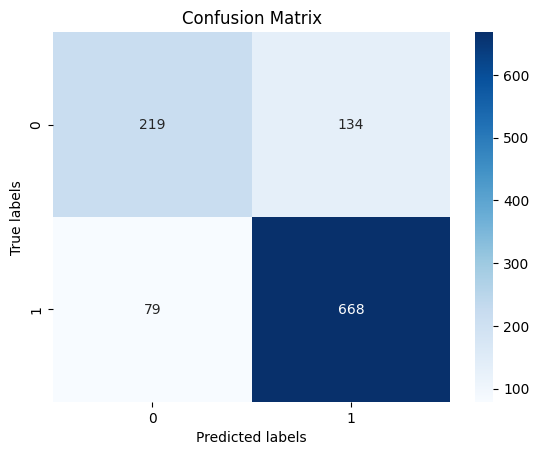

In [423]:
model = LogisticRegression(max_iter=3000, random_state=42).fit(X_train, y_train)
predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions)
test_recall = recall_score(y_test, predictions)
print("Accuracy: ", test_accuracy)
print("Precison: ", test_precision)
print("Recall: ", test_recall)

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

RF

Accuracy:  0.8327272727272728
Precison:  0.8620253164556962
Recall:  0.9007936507936508


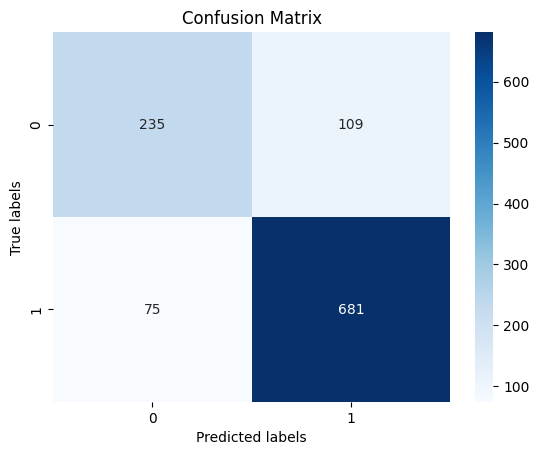

In [424]:
rf = RandomForestClassifier(random_state=42)
model = rf.fit(X_train_rf, y_train_rf)
predictions = model.predict(X_test_rf)
test_accuracy = accuracy_score(y_test_rf, predictions)
test_precision = precision_score(y_test_rf, predictions)
test_recall = recall_score(y_test_rf, predictions)
print("Accuracy: ", test_accuracy)
print("Precison: ", test_precision)
print("Recall: ", test_recall)

cm = confusion_matrix(y_test_rf, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()